# Modeling Churn

Here we will work on developping models that can predict the probability a TelCo customer will churn at a given point in time. We will score these models using 3 metrics: ROC-AUC, PR-AUC, and Log-Loss.

## Initializations

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_parquet("../data/processed.parquet") # Import Data

In [4]:
target = "Churn"
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"] # All of the numeric features names
non_numeric_features = df.drop([*numeric_features, target], axis= 1).columns # All of the non-numeric feature names (binary and categorical)
binary_features = non_numeric_features.drop(["gender", "MultipleLines", "InternetService", "Contract", "PaymentMethod", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
                                             "StreamingTV", "StreamingMovies"]) # Only the binary feature names
categorical_features = non_numeric_features.drop(binary_features) # Only the categorical feature names

## Pre-processing

In [5]:
binary_map = {'Yes': True, 'No': False, "True": True, "False": False}

In [6]:
df[[*binary_features, target]] = df[[*binary_features, target]].apply(lambda x: x.map(binary_map))
df[[*binary_features, target]] = df[[*binary_features, target]].astype(bool)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   string 
 1   SeniorCitizen     7043 non-null   bool   
 2   Partner           7043 non-null   bool   
 3   Dependents        7043 non-null   bool   
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   bool   
 6   MultipleLines     7043 non-null   string 
 7   InternetService   7043 non-null   string 
 8   OnlineSecurity    7043 non-null   string 
 9   OnlineBackup      7043 non-null   string 
 10  DeviceProtection  7043 non-null   string 
 11  TechSupport       7043 non-null   string 
 12  StreamingTV       7043 non-null   string 
 13  StreamingMovies   7043 non-null   string 
 14  Contract          7043 non-null   string 
 15  PaperlessBilling  7043 non-null   bool   
 16  PaymentMethod     7043 non-null   string 


In [8]:
X = df.drop(columns=target) # All the feature columns
y = df[target].astype(int) # The target
y = y.to_numpy()

## Test/Train and CV Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) # Splits our data into a train and a test set

### Cross-Validation

In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold() # Can use skf to split our data into 5 folds

## Logistic Regression

The baseline model we will be using is a full logistic regression without interaction effects since it is simple and easily interpretable

### Scaling
Logistic regression should have our features at similar scales since otherwise it will hurt model interpretability and also slow convergence

### One-Hot Encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# preprocessor will be the transformation we apply to all feature data before logistic regression
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features), # Applies a standard scaling to all numeric features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features), # Applies a one-hot encoding to all categorical features,
        ("bin", OrdinalEncoder(), binary_features) # Transforms all boolean data to a binary 0, 1 so Sklearn can interpret it
    ],
    remainder="passthrough"
)
preprocessor.fit(X_train, y_train)

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_na

In [12]:
X_train_processed = preprocessor.transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

### Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression().fit(X_train_processed, y_train)

In [50]:
X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

y_pred = logReg.predict(X_test_processed)
y_probs = logReg.predict_proba(X_test_processed)

### Evaluating

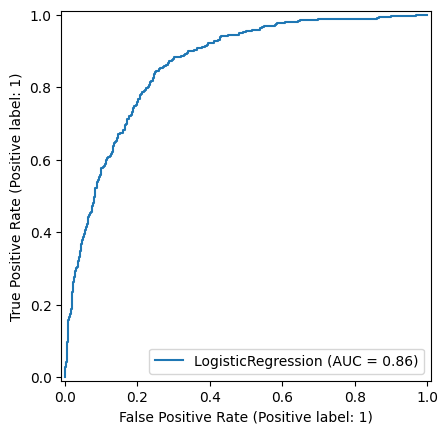

In [ ]:
from sklearn.metrics import RocCurveDisplay

rocCurve = RocCurveDisplay.from_estimator(logReg, X_test_processed, y_test) # Plot the ROC-AUC

plt.show()

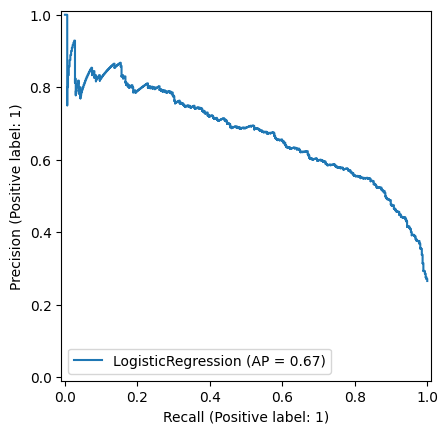

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(logReg, X_test_processed, y_test) # Plot the PR-AUC

plt.show()

In [ ]:
from sklearn.metrics import log_loss

loss = log_loss(y_test, y_probs) # Calculate the Log-Loss

print(f"Log Loss: {loss}")

Log Loss: 0.40095912890864144
